In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

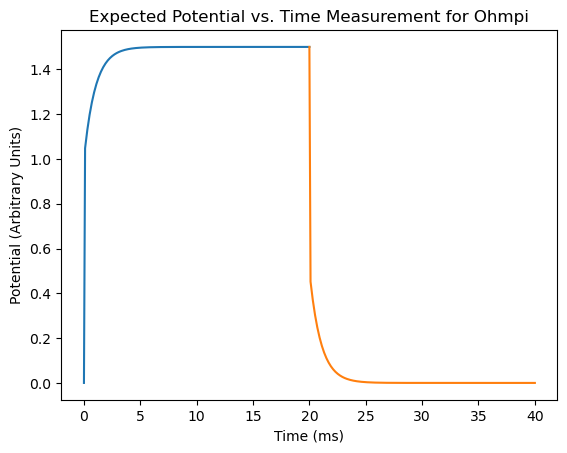

In [162]:
# Charging/discharging template

def charging(i, r, c, t, vs):
    v = i*r
    capv = v + vs*(1 - np.exp(-1*t/(r*c)))
    capv[0] = 0 # not sure if this is okay to do.
    return capv


def discharging(i, r, c, t, vs):
    v0 = i*r
    capv = vs*np.exp(-1*t/(r*c))
    capv[0] = v0 + vs
    return capv

def full_curve(i, r, c, t, vs, noiseLevel=0.02):
    t2 = t + max(t)
    return (np.concatenate((t, t2)), np.concatenate((charging(i, r, c, t, vs), discharging(i, r, c, t, vs))) + np.random.normal(0,noiseLevel,len(t)*2))

vs = 0.5
t = np.linspace(0, 20, 200)
v = charging(1, 1, 1, t, vs)

plt.plot(t, v)

# t = np.linspace(20, 40, 200)
v = discharging(1, 1, 1, t, vs)
plt.plot(t + 20, v)
plt.title("Expected Potential vs. Time Measurement for Ohmpi")
plt.xlabel("Time (ms)")
plt.ylabel("Potential (Arbitrary Units)")
            
plt.show()

Text(0, 0.5, 'Voltage (arb. units)')

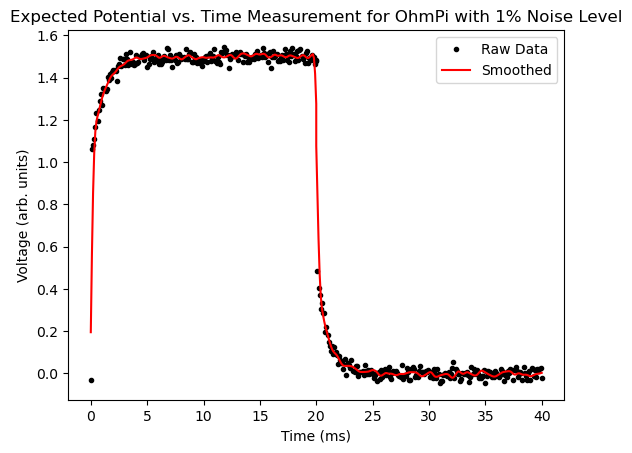

In [163]:
# Add noise and make a full curve

i = 1
r = 1
c = 1
vs = 0.5
plt.plot(full_curve(i, r, c, t, vs)[0], full_curve(i, r, c, t, vs)[1], "k.", label="Raw Data")
plt.plot(full_curve(i, r, c, t, vs)[0], smooth(full_curve(i, r, c, t, vs)[1]), "r", label="Smoothed")
plt.legend()
plt.title("Expected Potential vs. Time Measurement for OhmPi with 1% Noise Level")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (arb. units)")

In [164]:
# Compute DC potential by averaging last 1/3 of charging curve (as Ohmpi team does)
ts, vss = full_curve(i, r, c, t, vs)
dcv = np.average(vss[0:round(len(ts)/2)][round(len(ts)/3):-1])
dcv

1.5002788354112973

area = 0.4766835016510695
0.333271380803616


Text(0.5, 0, 'Voltage (V)')

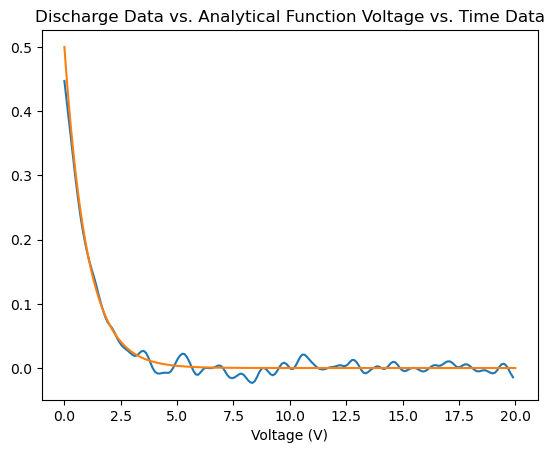

In [232]:
# Compute area under discharge curve
area = np.trapz(smooth(vss[round(len(ts)/2) + 1:]), ts[round(len(ts)/2) + 1:])
print("area =", area)

#Compute chargeability
mc = area/dcv
print(an_area/dcv)

plt.plot(ts[round(len(ts)/2) + 1:] - min(ts[round(len(ts)/2) + 1:]), smooth(vss[round(len(ts)/2) + 1:]))
plt.plot(ts[0:round(len(ts)/2)], func(ts[0:round(len(ts)/2)], const, vs))
plt.title("Discharge Data vs. Analytical Function Voltage vs. Time Data")
plt.xlabel("Time (ms)")
plt.xlabel("Voltage (V)")

In [235]:
#compute low and high frequency apparent resistivity

# set four electrodes on x line
a = 0
m = 1
n = 3
b = 4

k = 2*3.14*((abs(a-m))**-1 - (abs(b - m))**-1 - (abs(a - n))**-1 + (abs(b - n))**-1)**-1 # geometric factor

plf = k*dcv/i #low frequency resistivity
phf = k*(dcv*(1 - mc))/i # high frequency resistivity

phfan = k*(dcv - (1 - (an_area/dcv)))/i

print(plf, phf, phfan)

7.066313314787209 4.821134022010671 3.926021518372241


In [219]:
#https://stackoverflow.com/questions/5515720/python-smooth-time-series-data
import numpy
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=numpy.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=numpy.ones(window_len,'d')
        else:  
                w=eval('numpy.'+window+'(window_len)')
        y=numpy.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

In [240]:
# print the results
const = r*c
an_area = aanalytic(ts[int(len(ts)/2) + 1], ts[0], const, vs)

print(vss[round(len(ts)/2) + 1], func(ts[0] + 1, const, vs))
print(an_area)
print("Area: ", area)
print("Error in Area (%): ", 100*abs((an_area - area)/area))
print("Chargeability (Dimensionless): ", mc)
print("LF Resistivity: ", plf)
print("HF Resistivity: ", phf)
print("HF Resistivity Using Analytical Function: ", phfan)
print("Error in HF Resistivity:", 100*abs((phfan - phf)/phfan))

0.46224400065222965 0.18393972058572117
0.499999999067964
Area:  0.4766835016510695
Error in Area (%):  4.891400129464119
Chargeability (Dimensionless):  0.31772993819538087
LF Resistivity:  7.066313314787209
HF Resistivity:  4.821134022010671
HF Resistivity Using Analytical Function:  3.926021518372241
Error in HF Resistivity: 22.79948032504801


0.4999999989694232 0.5016993501504787 0.33987023691162865


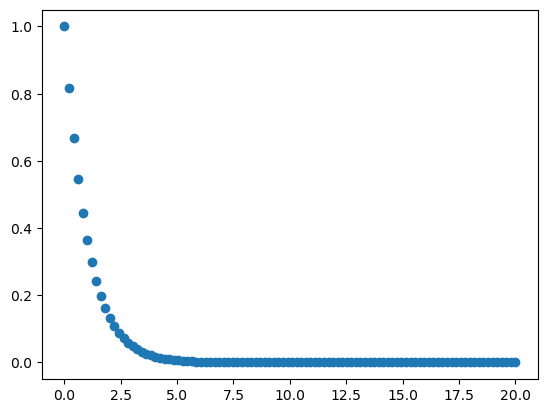

In [221]:
# UH OH. Looking into errors in approximating discharge curves with numpy trapz.
def func(t, c, vs):
    return vs*np.exp(-1*t/c)

def aanalytic(tf, t0, c, vs):
    return -1*vs*c*np.exp(-1*tf/c) - -1*vs*c*np.exp(-1*t0/c)

tnew = np.linspace(0, 20, 100)
plt.scatter(tnew, func(tnew, 1, 1))
# cesk = 2.5
# vesk = 0.05
f = func(tnew, c, vs)
anarea = aanalytic(tnew[-1], tnew[0], c, vs)
traparea = np.trapz(f, tnew)

print(anarea, traparea, abs((anarea - traparea)/anarea)*100)

/var/folders/_7/x_mxrhfx0gq6pt61nr_x9t880000gn/T/ipykernel_3291/1854419260.py:5: RuntimeWarning: divide by zero encountered in true_divide
  der = np.diff(vss) / np.diff(ts)


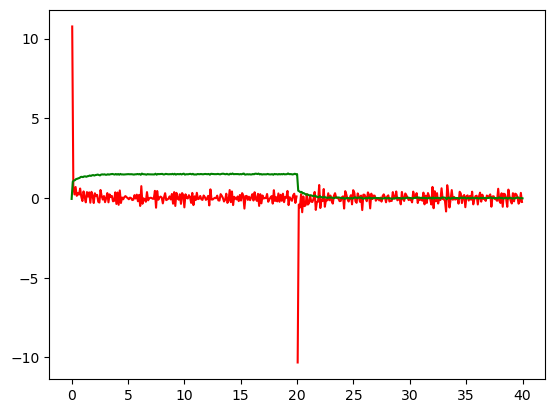

(array([199]),)


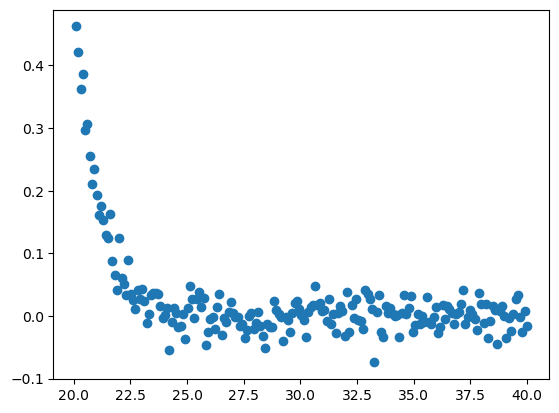

In [197]:
# Okay, nothing wrong with numpy trapz. 
# Figuring out how to seperate discharge curve from dc voltage.

# Plot derivative
der = np.diff(vss) / np.diff(ts)
x2 = (ts[:-1] + ts[1:]) / 2
plt.plot(x2, der, 'r', ts, vss, 'g')
plt.show()

# discharge should start at min of derivative
start = np.where(der==min(der))
print(start) # what we expected. We start at the index after this.
plt.scatter(ts[int(start[0]) + 2:], vss[int(start[0]) +2:])